# Deepfake Image Detection

Autori: Bucă Mihnea-Vicențiu; Căpatână Răzvan-Nicolae; Luculescu Teodor


## Model attribution

In this part we investigate whether we can identify the generative model that has produced a particular image. We formulate this task as a multiclass classification task, where the input is an image and the output is one of the five classes: “ldm”, “lama”, “pluralistic”, “repaint”, “real”. Experiment with the same methods as for the first task. Report the overall accuracy and the per class accuracy. Display a TSNE plot of the features color coded by the five classes.

### Data

The dataset can be downloaded from [here](https://drive.google.com/file/d/1NfLX9bZtOY8dO_yj3cU7pEHGmqItqjg2/view). It contains real images from the CelebAHQ dataset and locally manipulated images produced by four generators: [LDM](https://github.com/CompVis/latent-diffusion), [Pluralistic](https://github.com/lyndonzheng/Pluralistic-Inpainting), [LAMA](https://github.com/advimman/lama), [Repaint](https://github.com/andreas128/RePaint). You can read more about how this dataset was produced in Section 3.3 of the following paper:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We will extract the data for each model

In [2]:
import zipfile
import os

# path to the zip file
zip_file_path = 'drive/MyDrive/Proiect DeepLearning/DeepFMI_local_data.zip'

# the paths to the datasets within the zip file
dataset_paths = [
    'FMI_local_data/celebhq_real_data',
    'FMI_local_data/lama',
    'FMI_local_data/ldm',
    'FMI_local_data/pluralistic',
    'FMI_local_data/repaint'
]

# create a ZipFile object
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Iterate through the dataset paths
    for dataset_path in dataset_paths:
         zip_ref.extractall(members=[
            name for name in zip_ref.namelist()
            if name.startswith(dataset_path)
        ], path='/content/')  # Extract to the '/content/' directory


## Training Models

In [3]:
# important libraries
import torch
import glob
import pandas as pd
import torch.nn as nn
import torch.optim as optim

import numpy as np

import timm
import torch.nn.functional as F
import torch.optim as optim

from IPython.display import display, Markdown
from sklearn.metrics import average_precision_score
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torchvision.models as models
# from sam2.build_sam import build_sam2
# from sam2.sam2_image_predictor import SAM2ImagePredictor
from PIL import Image
from tqdm import tqdm  # for progress bar

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import h5py

In [4]:
class DeepFakeDataset(Dataset):
    """
    Takes a folder of real images and a list of folders of fake images and assigns labels (0 for real, 1/2/3/4 for each fake image).
    0 = real
    1 = lama
    2 = ldm
    3 = repaint
    4 = pluralistic
    """
    def __init__(self, real_folder: str, fake_folders: list[str], transform=None):
        # grab all .png under each
        self.real_paths = sorted(glob.glob(os.path.join(real_folder, '*.png')))
        self.samples = [(p, 0) for p in self.real_paths]

        self.fake_paths = []
        for label, fake_folder in enumerate(fake_folders):
            current_fake_paths = sorted(glob.glob(os.path.join(fake_folder, '*.png')))
            self.fake_paths += current_fake_paths
            self.samples += [(p, label + 1) for p in current_fake_paths]

        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

In [5]:
def make_model_dataloaders(
    root_dir: str,            # contains subfolders: lama/, ldm/, repaint/, pluralistic/
    real_root: str,           # path to celebhq_real_data
    model_names: list[str],   # ['lama','ldm','repaint','pluralistic']
    splits: list[str] = ('train','valid','test'),
    batch_size: int = 16,
    img_size: int = 256,
    num_workers: int = 2
):
    """
    Returns a dict:
      { split: DataLoader, … }
      Each loader mixes real vs models' fake images.
    """

    # strong augmentation for train
    train_tf = transforms.Compose([
        transforms.RandomResizedCrop(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize((0.4914,0.4822,0.4465), (0.2023,0.1994,0.2010))
    ])

    # weak augmentation for val/test
    test_tf = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914,0.4822,0.4465), (0.2023,0.1994,0.2010))
    ])

    dataloaders = {}
    for split in splits:
        real_folder = os.path.join(real_root, split)
        fake_folders = [os.path.join(root_dir, model_name, split) for model_name in model_names]

        tf = train_tf if split=='train' else test_tf
        ds = DeepFakeDataset(real_folder, fake_folders, transform=tf)

        dataloaders[split] = DataLoader(
            ds,
            batch_size=batch_size,
            shuffle=(split=='train'),
            num_workers=num_workers,
            pin_memory=True
        )

    return dataloaders

In [6]:
root = "/content/FMI_local_data"
deepfake_models = ["lama", "ldm", "repaint", "pluralistic"]
loaders = make_model_dataloaders(
    root_dir=root,
    real_root=os.path.join(root, "celebhq_real_data"),
    model_names=deepfake_models,
    splits=['train', 'valid', 'test'],
    batch_size=16,
    img_size=256,
    num_workers=2
)

# test
train_loader = loaders['train']
print(f"train batches: {len(train_loader)}")

train batches: 2813


In [7]:
import gc

def train_timm(
    dataloaders,         # dict: { name: {'train','valid','test'} DataLoaders }
    num_classes: int = 5,
    num_epochs: int = 2,
    lr_head: float = 1e-3,
    lr_ft: float = 1e-4,
    weight_decay: float = 1e-5,
    freeze_epochs: int = 5,
    device: str = None,
    model = None
):
    """
    Fine-tune Xception41 pretrained on ImageNet-1K (supervised)
    - Phase 1: freeze backbone, train only the new classifier head
    - Phase 2: unfreeze entire network and fine-tune
    """
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    results = {}

    label_to_model = {
        0: 'real',
        1: 'lama',
        2: 'ldm',
        3: 'repaint',
        4: 'pluralistic'
    }

    print(f"\n=== [Xception-Imagenet] Training ===")

    # 1) Load Xception41 with supervised ImageNet‐1K weights
    '''
    model = timm.create_model(
        'xception41',
        pretrained='imagenet',
        num_classes=num_classes
    ).to(device)
    '''
    model.to(device)

    # 2) Phase 1: freeze all layers except the classifier head
    for p in model.parameters():
        p.requires_grad = False
    # timm’s get_classifier() returns the final Linear
    for p in model.get_classifier().parameters():
        p.requires_grad = True

    optimizer = optim.Adam(
        model.get_classifier().parameters(),
        lr=lr_head,
        weight_decay=weight_decay
    )
    scheduler = optim.lr_scheduler.StepLR(
        optimizer, step_size=freeze_epochs, gamma=0.1
    )
    criterion = nn.CrossEntropyLoss()

    # Head-only training
    head_only_train_label_cnts = []
    head_only_train_accs = []
    head_only_all_train_accs = []

    for epoch in range(1, freeze_epochs + 1):

        head_only_train_label_cnts.append([0] * num_classes)
        head_only_train_accs.append([0] * num_classes)

        model.train()
        running_loss = 0.0
        for imgs, labels in dataloaders['train']:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            logits = model(imgs)             # raw logits
            loss = criterion(logits, labels) # CE on logits
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * imgs.size(0)

            preds = logits.argmax(dim=1)
            for pred, label in zip(preds, labels):
                head_only_train_label_cnts[-1][label] += 1
                if pred == label:
                    head_only_train_accs[-1][label] += 1

        scheduler.step()
        avg = running_loss / len(dataloaders['train'].dataset)
        print(f" [Head] Epoch {epoch}/{freeze_epochs} — loss: {avg:.4f}")

        train_acc = np.sum(np.array(head_only_train_accs[-1])) / np.sum(np.array(head_only_train_label_cnts[-1]))
        head_only_all_train_accs.append(train_acc)
        print(f" ▶ train acc {train_acc:.4%}")

        for label in range(num_classes):
            if head_only_train_label_cnts[-1][label] != 0:
              crt_train_acc = head_only_train_accs[-1][label] / head_only_train_label_cnts[-1][label]
            else:
              crt_train_acc = 0
            print(f"   ▶ train acc {label_to_model[label]} {crt_train_acc:.4%}")

    # 3) Phase 2: unfreeze everything, fine-tune
    for p in model.parameters():
        p.requires_grad = True

    optimizer = optim.Adam(
        model.parameters(),
        lr=lr_ft,
        weight_decay=weight_decay
    )
    scheduler = optim.lr_scheduler.StepLR(
        optimizer, step_size=5, gamma=0.1
    )

    fine_tune_train_label_cnts = []
    fine_tune_train_accs = []
    fine_tune_all_train_accs = []

    for epoch in range(freeze_epochs + 1, num_epochs + 1):

        fine_tune_train_label_cnts.append([0] * num_classes)
        fine_tune_train_accs.append([0] * num_classes)

        model.train()
        running_loss = 0.0
        for imgs, labels in dataloaders['train']:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            logits = model(imgs)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * imgs.size(0)

            preds = logits.argmax(dim=1)
            for pred, label in zip(preds, labels):
                fine_tune_train_label_cnts[-1][label] += 1
                if pred == label:
                    fine_tune_train_accs[-1][label] += 1

        scheduler.step()
        avg = running_loss / len(dataloaders['train'].dataset)
        print(f" [Fine-tune] Epoch {epoch}/{num_epochs} — loss: {avg:.4f}")

        train_acc = np.sum(np.array(fine_tune_train_accs[-1])) / np.sum(np.array(fine_tune_train_label_cnts[-1]))
        fine_tune_all_train_accs.append(train_acc)
        print(f" ▶ train acc {train_acc:.4%}")

        for label in range(num_classes):
            if fine_tune_train_label_cnts[-1][label] != 0:
              crt_train_acc = fine_tune_train_accs[-1][label] / fine_tune_train_label_cnts[-1][label]
            else:
              crt_train_acc = 0
            print(f"   ▶ train acc {label_to_model[label]} {crt_train_acc:.4%}")

    # 4) Validation
    model.eval()
    correct = total = 0

    valid_label_cnts = [0] * num_classes
    valid_accs = [0] * num_classes

    valid_features = []
    valid_labels = []

    with torch.no_grad():
        for imgs, labels in dataloaders['valid']:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs).argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            for pred, label in zip(preds, labels):
                valid_label_cnts[label] += 1
                if pred == label:
                    valid_accs[label] += 1

            feats = model.forward_features(imgs)
            valid_features.append(feats.detach().cpu())
            valid_labels.append(labels.detach().cpu())

    valid_features = torch.cat(valid_features, dim=0).numpy() # from many tensors for each batch to just one
    valid_labels = torch.cat(valid_labels, dim=0).numpy()

    valid_acc = correct / total
    print(f" ▶ valid acc {valid_acc:.4%}")

    for label in range(num_classes):
        if valid_label_cnts[label] != 0:
          crt_valid_acc = valid_accs[label] / valid_label_cnts[label]
        else:
          crt_valid_acc = 0
        print(f"   ▶ valid acc {label_to_model[label]} {crt_valid_acc:.4%}")


    results = {
        'model': model.state_dict(), # state_dict instead of model
        'valid_acc': valid_acc,

        'head_only_all_train_acc': head_only_all_train_accs[-1] if len(head_only_all_train_accs) > 0 else 0,
        'fine_tune_all_train_acc': fine_tune_all_train_accs[-1] if len(fine_tune_all_train_accs) > 0 else 0,

        'valid_features': valid_features,
        'valid_labels': valid_labels
    }
    for label in range(num_classes):
      if head_only_train_label_cnts[-1][label] != 0:
        results[f'head_only_train_acc_{label_to_model[label]}'] = head_only_train_accs[-1][label] / head_only_train_label_cnts[-1][label]
      else:
        results[f'head_only_train_acc_{label_to_model[label]}'] = 0
      if len(fine_tune_all_train_accs) > 0:
        if fine_tune_train_label_cnts[-1][label] != 0:
          results[f'fine_tune_train_acc_{label_to_model[label]}'] = fine_tune_train_accs[-1][label] / fine_tune_train_label_cnts[-1][label]
        else:
          results[f'fine_tune_train_acc_{label_to_model[label]}'] = 0

      if valid_label_cnts[label] != 0:
        results[f'valid_acc_{label_to_model[label]}'] = valid_accs[label] / valid_label_cnts[label]
      else:
        results[f'valid_acc_{label_to_model[label]}'] = 0

    # clear GPU memory
    torch.cuda.empty_cache()
    gc.collect()

    return results

In [ ]:
'''
results = train_timm(
    dataloaders=loaders,
    num_classes = 5,
    num_epochs = 2,
    lr_head = 1e-3,
    lr_ft = 1e-4,
    weight_decay = 1e-5,
    freeze_epochs = 1,
)
'''

In [8]:
save_path = 'drive/MyDrive/Proiect DeepLearning/Task-2/Second-Method/results.pth'

save_path_dir = 'drive/MyDrive/Proiect DeepLearning/Task-2/Second-Method/'
os.makedirs(save_path_dir, exist_ok=True)  # Ensure the directory exists

In [9]:
# helper functions to read/write large data dict from/to storage (memory-efficient)

def save_dict_to_hdf5(data, path, model_path):
    with h5py.File(path, 'w') as h5file:
      for k, v in data.items():
        if k == 'model':
          torch.save(v, model_path)
        else:
          _recursively_save(h5file, str(k), v)

def _recursively_save(h5group, key, value):
    if isinstance(value, dict):
        grp = h5group.create_group(key)
        for k, v in value.items():
            _recursively_save(grp, str(k), v)

    elif isinstance(value, (list, tuple)):
        grp = h5group.create_group(key)
        grp.attrs['__type__'] = 'tuple' if isinstance(value, tuple) else 'list'
        for i, item in enumerate(value):
            _recursively_save(grp, str(i), item)

    elif isinstance(value, torch.Tensor):
        dset = h5group.create_dataset(key, data=value.cpu().numpy())
        dset.attrs['__type__'] = 'torch_tensor'

    elif isinstance(value, np.ndarray):
        h5group.create_dataset(key, data=value)

    elif isinstance(value, (str, int, float, bool)):
        dset = h5group.create_dataset(key, data=value)
        dset.attrs['__type__'] = type(value).__name__

    elif value is None:
        grp = h5group.create_group(key)
        grp.attrs['__type__'] = 'none'

    else:
        raise TypeError(f'Unsupported data type: {type(value)}')


def load_dict_from_hdf5(path, model_path):
    model_state_dict = torch.load(model_path, map_location='cpu')
    results = {}
    with h5py.File(path, 'r') as h5file:
        results =  _recursively_load(h5file['/'])
    results['model'] = model_state_dict

    return results

def _recursively_load(h5obj):
    if isinstance(h5obj, h5py.Dataset):
        data = h5obj[()]
        dtype = h5obj.attrs.get('__type__')

        if dtype == 'torch_tensor':
            return torch.tensor(data)
        elif dtype == 'int':
            return int(data)
        elif dtype == 'float':
            return float(data)
        elif dtype == 'str':
            return data.decode() if isinstance(data, bytes) else str(data)
        elif dtype == 'bool':
            return bool(data)
        else:
            return data  # numpy array or other

    elif isinstance(h5obj, h5py.Group):
        dtype = h5obj.attrs.get('__type__')
        if dtype == 'list' or dtype == 'tuple':
            items = []
            for key in sorted(h5obj.keys(), key=lambda x: int(x)):
                items.append(_recursively_load(h5obj[key]))
            return tuple(items) if dtype == 'tuple' else items
        elif dtype == 'none':
            return None
        else:
            return {key: _recursively_load(h5obj[key]) for key in h5obj}


In [10]:
def loop_training():
  save_path_base = save_path_dir

  num_epochs = 10

  model_name = 'xception41'
  num_classes = 5

  model = timm.create_model(
        model_name,
        pretrained='imagenet',
        num_classes=num_classes
  )

  results = {}

  for i in range(1, num_epochs+1):
    if i > 1:
      results.clear()
      results = load_dict_from_hdf5(save_path_base + f'results_{i-1}.pth', save_path_base + f'model_state_dict_{i-1}.pth')
      # results = torch.load(save_path_base + f'results_{i-1}.pth')
      model.load_state_dict(results['model'])

    results = train_timm(
        dataloaders=loaders,
        num_classes = 5,
        num_epochs = 2,
        lr_head = 1e-3,
        lr_ft = 1e-4,
        weight_decay = 1e-5,
        freeze_epochs = 1,
        model = model
    )

    save_dict_to_hdf5(results, save_path_base + f'results_{i}.pth', save_path_base + f'model_state_dict_{i}.pth')
    print(f"Results saved to: results_{i}.pth and model_state_dict_{i}.pth")
    # torch.save(results, save_path_base + f'results_{i}.pth')


In [ ]:
loop_training()


=== [Xception-Imagenet] Training ===
 [Head] Epoch 1/1 — loss: 0.4041
 ▶ train acc 82.5263%
   ▶ train acc real 72.6444%
   ▶ train acc lama 97.2889%
   ▶ train acc ldm 97.9000%
   ▶ train acc repaint 58.4621%
   ▶ train acc pluralistic 86.3333%
 [Fine-tune] Epoch 2/2 — loss: 0.3911
 ▶ train acc 83.1174%
   ▶ train acc real 75.2333%
   ▶ train acc lama 98.2778%
   ▶ train acc ldm 97.9000%
   ▶ train acc repaint 57.9398%
   ▶ train acc pluralistic 86.2333%
 ▶ valid acc 89.4889%
   ▶ valid acc real 85.0000%
   ▶ valid acc lama 100.0000%
   ▶ valid acc ldm 100.0000%
   ▶ valid acc repaint 73.6667%
   ▶ valid acc pluralistic 88.7778%
Results saved to: results_2.pth and model_state_dict_1.pth

=== [Xception-Imagenet] Training ===
 [Head] Epoch 1/1 — loss: 0.3159
 ▶ train acc 86.1641%
   ▶ train acc real 78.6444%
   ▶ train acc lama 99.0889%
   ▶ train acc ldm 99.1222%
   ▶ train acc repaint 63.7182%
   ▶ train acc pluralistic 90.2444%


In [ ]:
'''
import os
# save models in drive/MyDrive/Proiect DeepLearning/Task-2/Second-Method
os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Ensure the directory exists
torch.save(results, save_path)
print(f"Results saved to: {save_path}")
'''

In [11]:
def plot_tsne(features, labels, num_classes=5):
  tsne = TSNE(n_components=2, random_state=17, perplexity=30)
  tsne_features = tsne.fit_transform(features)

  plt.figure(figsize=(10, 8))

  label_to_model = {
      0: 'real',
      1: 'lama',
      2: 'ldm',
      3: 'repaint',
      4: 'pluralistic'
  }

  label_to_color = {
      0: 'green',
      1: 'red',
      2: 'blue',
      3: 'yellow',
      4: 'purple'
  }

  for label in range(num_classes):
    mask = labels == label

    plt.scatter(
        tsne_features[mask, 0],
        tsne_features[mask, 1],
        color=label_to_color[label],
        label=label_to_model[label], alpha=0.5
    )

  plt.legend()
  plt.title('TSNE Plot of Features')
  plt.xlabel('1st Dimension')
  plt.ylabel('2nd Dimension')
  # plt.grid(True)
  plt.show()

In [12]:
epoch_idx = 2
results = load_dict_from_hdf5(save_path_dir + f'results_{epoch_idx}.pth', save_path_dir + f'model_state_dict_{epoch_idx}.pth')


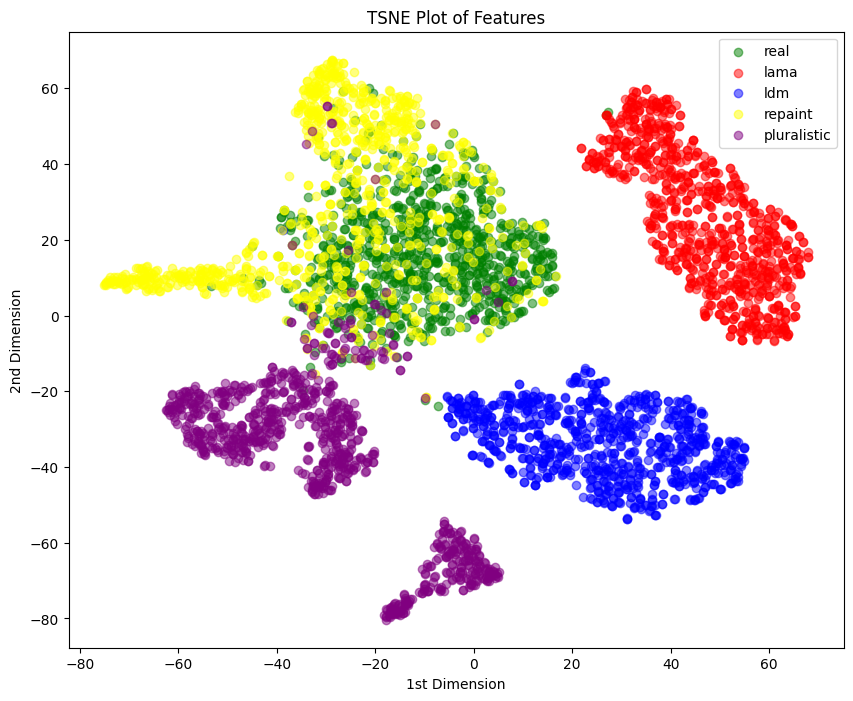

In [13]:
plot_tsne(results['valid_features'].mean(axis=(2, 3)), results['valid_labels'])